In [2]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats
from climate_helpers import giss_temp_data, years, dTs, MonomialBasis, ChebyshevBasis
from stanfitter import StanFitter

In [3]:
lin_regn_code = """
data {
    int<lower=0> n; // number of times sampled
    int<lower=0> m; // number of coeff = deg + 1
    matrix[n,m] basis; // basis funcs, aka design matrix #in helper compute
    vector[n] dT; // temp change
}

parameters {
    vector[m] beta;  // coeficients
    real<lower=0> sigma;  // noise scale
}

model {
    // FILL IN HERE; SEE STAN MANUAL
    beta ~ normal(0, 2.); // prior is a wide normal
    sigma ~ exponential(0.5);
    dT ~ normal(basis*beta,sigma);

}
"""

# Uncomment to compile finished code:
fitter = StanFitter(lin_regn_code, name='lin_regn')

Using cached StanModel from cached-model-lin_regn-f848187463150fc8b49fc4f95b81628b.pkl...


In [4]:
xyears = arange(years[0], 2051.)

def fit_model(fitter, Poly, deg, csig, n_iter=1000, n_chains=4,
              years=years, dTs=dTs, xyears=xyears):
    """
    Fit the data and summarize results.

    Parameters
    ----------
    
    fitter : StanFitter instance
    
    Poly : Polynomial basis class
    
    deg : int
        Degree of polynomial to fit

    csig : float
        Coeffient prior standard deviation

    n_iter, n_chains : int
        The number of iterations per chain, and number of chains, for Stan fits

    years, dTs, xyears : float arrays
        Data (years, dTs) and extended years covering data and prediction
        interval (xyears)
    """
    nbeta = deg + 1  # number of coefs
    # Build a basis over the fit+prediction interval.
    poly = Poly(deg, xyears, sigma=csig)
    # For fitting the data, pull out the part spanning years.
    data_basis = poly.basis[:len(years),:]
    # Data dict for Stan:
    data = dict(n=len(years), m=nbeta, basis=data_basis, dT=dTs)

    # Do the fit, MCMC and optimization:
    fitter.set_data(data)
    fit = fitter.sample(n_iter, n_chains)
    mode = fitter.mode()

    # Plot dTs:
    temp_fig = figure()
    temp_ax = axes()
    plot(years, dTs, 'b-', alpha=.3)
    plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
    xlabel('Year')
    ylabel(r'$\Delta T$ (C)')
    xlim(xyears[0], xyears[-1])
    ylim(-1.5, 1.5)
    
    #plot 40 polynomial samples)
    ind=fit.subsample_indices(40)
    data_basis_n = poly.basis[:len(xyears),:]

    for i in range(40):
        ch=int(ind[i]/500)
        mu=fit.chains[ind[i]-ch*500,ch,0:nbeta]
        #print(mu)
        sig=fit.chains[ind[i]-ch*500,ch,nbeta]
        mm=Poly(deg, xyears,sigma=sig)
        plot(xyears,mm.func(mu), '-',alpha=.4)  

    #Plot a thick dashed curve showing the polynomial corresponding to the mode.
    mmm=Poly(deg, xyears,sigma=mode.sigma)
    plot(xyears,mmm.func(mode.beta), '--',alpha=1,color='black',linewidth=6)
    
    #Plot a single error bar somewhere along the curve displaying the value of σ at the mode.
    errorbar(xyears[20],mmm.func(mode.beta)[20], yerr=mode.sigma,elinewidth=4,capsize=10)
    return fit, mode


Gradient evaluation took 9.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 9.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.229631 seconds (Warm-up)
               0.197516

(<stanfitter.StanFitResults at 0x7fbc5c3e43d0>,
 <stanfitter.ImmutableAttrDict at 0x7fbc5c832bd0>)

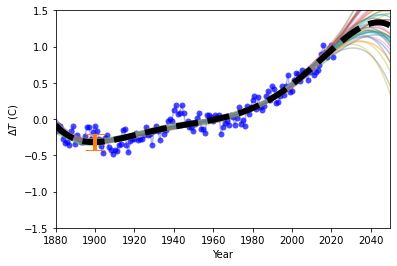

In [6]:
fit_model(fitter, ChebyshevBasis, deg=5, csig=2., n_iter=1000, n_chains=4,years=years, dTs=dTs, xyears=xyears)


Gradient evaluation took 0.000303 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.03 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000129 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
Adjust your expectations accordingly!



Iteration:   1 / 1000 [  0%]  (Warmup)
Gradient evaluation took 0.000452 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.52 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000127 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.27 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (W

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
I

(<stanfitter.StanFitResults at 0x7fbc5c7ef090>,
 <stanfitter.ImmutableAttrDict at 0x7fbc5c832ed0>)

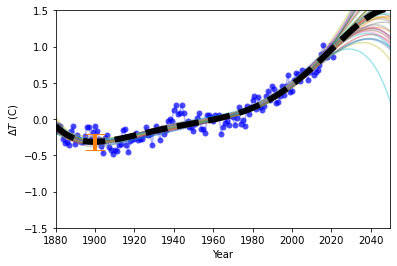

In [7]:
fit_model(fitter, MonomialBasis, deg=5, csig=2., n_iter=1000, n_chains=4,years=years, dTs=dTs, xyears=xyears)


Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.00011 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.195608 seconds (Warm-up)
               0.202669 seconds (Sampling)
               0.398277 seconds (Total)

Iteration: 900 / 

(<stanfitter.StanFitResults at 0x7fa87eb37350>,
 <stanfitter.ImmutableAttrDict at 0x7fa87f09ded0>)

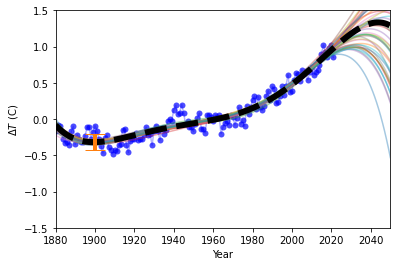

In [16]:
fit_model(fitter, ChebyshevBasis, deg=5, csig=2., n_iter=1000, n_chains=4,years=years, dTs=dTs, xyears=xyears)